In [2]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

#SavedModel 包含一个完整的 TensorFlow 程序，包括训练的参数（即 tf.Variable）和计算。它不需要原始模型构建代码就可以运行，因此，对于使用 TFLite、TensorFlow.js、TensorFlow Serving 或 TensorFlow Hub 共享或部署非常有用。

#您可以使用以下 API 以 SavedModel 格式保存和加载模型：
#   低级 tf.saved_model API。本文档将详细介绍如何使用此 API。
#       保存：tf.saved_model.save(model, path_to_dir)
#       加载：model = tf.saved_model.load(path_to_dir)
#   高级tf.keras.Model API。请参阅 Keras 保存和序列化指南。
#   如果您只是想在训练中保存/加载权重，请参阅检查点指南。

#小心：TensorFlow 模型是代码，对于不受信任的代码，一定要小心。请参阅安全使用 TensorFlow 以了解详情。

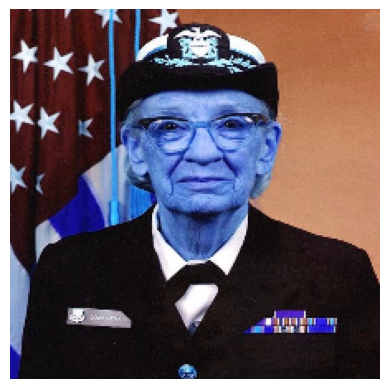

In [3]:

##图片下载异常，从本地导入

#file = tf.keras.utils.get_file(
#    "grace_hopper.jpg",
#    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
#img = tf.keras.utils.load_img(file, target_size=[224, 224])

import cv2 
image_path = 'res/grace_hopper.jpg'  
img = cv2.imread(image_path)
img = cv2.resize(img,[224,224])

plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

In [4]:
x.shape

(1, 224, 224, 3)

In [5]:
#我们会使用 Grace Hopper 的一张照片作为运行示例，并使用一个预先训练的 Keras 图像分类模型

#网络故障，本地加载
#labels_path = tf.keras.utils.get_file(
#    'ImageNetLabels.txt',
#    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

labels_path = 'res/ImageNetLabels.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [6]:

#网络故障，下载模型到本地加载也报错，干脆自己构建个模型
#pretrained_model = tf.keras.applications.MobileNet()

import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Flatten(input_shape=[ 224, 224, 3], name="inputs"),
        layers.Dense(512, activation="relu", name="layer1"),
        layers.Dense(512, activation="relu", name="layer2"),
        layers.Dense(1000, activation="softmax",name="predictions"),  #查看ImageNetLabels.txt可知有1001个类
    ]
)

result_before_save = model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)  #效果不好，没预测对。。。


Result before saving:
 ['mouse' 'barn' 'vizsla' "jack-o'-lantern" 'desktop computer']


In [7]:
#保存路径遵循 TensorFlow Serving 使用的惯例，
#路径的最后一个部分（此处为 1/）是模型的版本号——它可以让 Tensorflow Serving 之类的工具推断相对新鲜度。
mobilenet_save_path = "__MobileNet/mobilenet/1/" #os.path.join(tmpdir, "__MobileNet/mobilenet/1/")
tf.saved_model.save(model, mobilenet_save_path)

INFO:tensorflow:Assets written to: __MobileNet/mobilenet/1/assets


INFO:tensorflow:Assets written to: __MobileNet/mobilenet/1/assets


In [8]:
#您可以使用 tf.saved_model.load 将 SavedModel 加载回 Python，并查看 Admiral Hopper 的图像是如何分类的。
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [9]:
#导入的签名总是会返回字典
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


In [10]:
infer

<ConcreteFunction (*, inputs_input: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs_input')) -> Dict[['predictions', TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')]] at 0x1EDB7D245D0>

In [11]:
#从 SavedModel 运行推断会产生与原始模型相同的结果。
labeling = infer(tf.constant(x))[model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['mouse' 'barn' 'vizsla' "jack-o'-lantern" 'desktop computer']


In [12]:
## 7.2.2 保存自定义模型
#tf.saved_model.save 支持保存 tf.Module 对象及其子类，如 tf.keras.Layer 和 tf.keras.Model。
## 1. 我们来看一个保存和恢复 tf.Module 的示例。
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()


In [13]:
#当您保存 tf.Module 时，任何 tf.Variable 特性、tf.function 装饰的方法以及通过递归遍历找到的 tf.Module 都会得到保存。
#   （参阅检查点教程，了解此递归便利的详细信息。）但是，所有 Python 特性、函数和数据都会丢失。也就是说，当您保存 tf.function 时，不会保存 Python 代码。
#如果不保存 Python 代码，SavedModel 如何知道怎样恢复函数？
#简单地说，tf.function 的工作原理是，通过跟踪 Python 代码来生成 ConcreteFunction（一个可调用的 tf.Graph 包装器）。当您保存 tf.function 时，
#   实际上保存的是 tf.function 的 ConcreteFunction 缓存。
#要详细了解 tf.function 与 ConcreteFunction 之间的关系，请参阅 tf.function 指南。
module_no_signatures_path = "__MobileNet/module_no_signatures/" # os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

Tracing with Tensor("x:0", shape=(), dtype=float32)
Saving model...
Tracing with Tensor("x:0", shape=(), dtype=float32)
INFO:tensorflow:Assets written to: __MobileNet/module_no_signatures/assets


INFO:tensorflow:Assets written to: __MobileNet/module_no_signatures/assets


In [14]:
### 7.2.3 加载和使用自定义模型
#在 Python 中加载 SavedModel 时，所有 tf.Variable 特性、tf.function 装饰方法和 tf.Module 都会按照与原始保存的 tf.Module 相同对象结构进行恢复。
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

In [15]:
#由于没有保存 Python 代码，所以使用新输入签名调用 tf.function 会失败：
try:
    imported(tf.constant([3.]))
except  Exception  as e:
    print(e)

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'x:0' shape=(1,) dtype=float32>
  Keyword arguments: {}

 Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(), dtype=tf.float32, name='x')
  Keyword arguments: {}


In [16]:
## 1.基本微调
#可以使用变量对象，还可以通过导入的函数向后传播。对于简单情形，这足以支持 SavedModel 的微调（即重新训练）。
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss


In [17]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


In [18]:
## 2. 一般微调
#与普通 __call__ 相比，Keras 的 SavedModel 提供了更多详细信息来解决更复杂的微调情形。TensorFlow Hub 建议在共享的 SavedModel 中提供以下详细信息（如果适用），以便进行微调：
#   如果模型使用随机失活，或者是训练与推理之间的前向传递不同的另一种技术（如批次归一化），
#       则 __call__ 方法会获取一个可选的 Python 值 training= 参数。该参数的默认值为 False，但可将其设置为 True。
#   对于变量的对应列表，除了 __call__ 特性，还有 .variable 和 .trainable_variable 特性。在微调过程中，.trainable_variables 省略了一个变量，
#        该变量原本可训练，但打算将其冻结。
#   对于 Keras 等将权重正则化项表示为层或子模型特性的框架，还有一个 .regularization_losses 特性。它包含一个零参数函数的列表，这些函数的值应加到总损失中。

#回到初始 MobileNet 示例，您可以看到一些具体操作：
loaded = tf.saved_model.load(mobilenet_save_path)  #此处是自定义模型
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 6 trainable variables: layer1/kernel:0, layer1/bias:0, layer2/kernel:0, layer2/bias:0, predictions/kernel:0, ...


In [19]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 0 non-trainable variables: , ...


In [20]:
### 7.2.4 导出时指定签名

#TensorFlow Serving 之类的工具和 saved_model_cli 可以与 SavedModel 交互。为了帮助这些工具确定要使用的 ConcreteFunction，我们需要指定应用签名。
#   tf.keras.Model 会自动指定应用签名，但是，对于自定义模块，我们必须明确声明应用签名。

#重要提示：除非您需要使用 Python 将模型导出到 TensorFlow 2.x 之外的环境，否则您不需要明确导出签名。如果您在寻找为特定函数强制输入签名的方式，
#   请参阅 tf.function 的 input_signature 参数。

#默认情况下，自定义 tf.Module 中不会声明签名。
assert len(imported.signatures) == 0

In [21]:
#要声明服务上线签名，请使用 signatures 关键字参数指定 ConcreteFunction。
#   当指定单个签名时，签名键为 'serving_default'，并将保存为常量 tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY。
module_with_signature_path = "__MobileNet/module_with_signature/" #os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)


Tracing with Tensor("x:0", dtype=float32)
Tracing with Tensor("x:0", dtype=float32)
INFO:tensorflow:Assets written to: __MobileNet/module_with_signature/assets


INFO:tensorflow:Assets written to: __MobileNet/module_with_signature/assets


In [22]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())

['serving_default']

In [23]:
#要导出多个签名，请将签名键的字典传递给 ConcreteFunction。每个签名键对应一个 ConcreteFunction。
module_multiple_signatures_path = "__MobileNet/module_with_multiple_signatures/" #os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

INFO:tensorflow:Assets written to: __MobileNet/module_with_multiple_signatures/assets


INFO:tensorflow:Assets written to: __MobileNet/module_with_multiple_signatures/assets


In [24]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

['serving_default', 'array_input']

In [25]:
#默认情况下，输出张量名称非常通用，如 output_0。为了控制输出的名称，请修改 tf.function，
#   以便返回将输出名称映射到输出的字典。输入的名称来自 Python 函数参数名称。


In [37]:
###<补充> 7.2.5 导出时指定签名 - 多输入多输出

import tensorflow as tf  
from tensorflow.keras.layers import Input, Dense, concatenate  
from tensorflow.keras.models import Model  
  
# 定义两个输入  
input_1 = Input(shape=(10,), name='input_1')  
input_2 = Input(shape=(5,), name='input_2')  
  
# 定义两个简单的隐藏层  
hidden_1 = Dense(64, activation='relu')(input_1)  
hidden_2 = Dense(32, activation='relu')(input_2)  
  
# 连接两个隐藏层的输出  
shared_layer = concatenate([hidden_1, hidden_2])  
  
# 定义两个输出层  
output_1 = Dense(1, name='output_1')(shared_layer)  
output_2 = Dense(1, name='output_2')(shared_layer)  
  
# 创建模型，指定多个输入和输出  
model = Model(inputs=[input_1, input_2], outputs=[output_1, output_2]) 
  
# 编译模型（如果需要的话）  
model.compile(optimizer='adam', loss='binary_crossentropy')  
  
# 定义模型的签名  
@tf.function(input_signature=[  
    tf.TensorSpec(shape=[None, 10], dtype=tf.float32, name='input_1'),  
    tf.TensorSpec(shape=[None, 5], dtype=tf.float32, name='input_2')  
])  
def serve(input_1, input_2):  
    return model([input_1, input_2])  
  
# 签名字典  
signature = {  
    'serving_default': serve  
}  
  
# 保存模型的路径  
export_path = "__MobileNet/signature_with_multiple_input_output"  
  
# 保存模型，包括签名  
tf.saved_model.save(model, export_path, signatures=signature)

INFO:tensorflow:Assets written to: __MobileNet/signature_with_multiple_input_output\assets


INFO:tensorflow:Assets written to: __MobileNet/signature_with_multiple_input_output\assets


In [38]:
# 加载模型  
loaded_model = tf.saved_model.load(export_path)  
  
# 获取签名  
serve_signature = loaded_model.signatures['serving_default']  
  
# 创建一些模拟输入数据  
input_data_1 = tf.random.normal(shape=(1, 10))  
input_data_2 = tf.random.normal(shape=(1, 5))  
  
# 使用签名进行推理  
output_data = serve_signature(input_1=input_data_1, input_2=input_data_2)  
  
# 输出结果  
print(output_data)

{'output_1': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.19597101]], dtype=float32)>, 'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.775167]], dtype=float32)>}


In [39]:
serve_signature

<ConcreteFunction (*, input_1: TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_1'), input_2: TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_2')) -> Dict[['output_1', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_1')], ['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x1EE44FB0650>

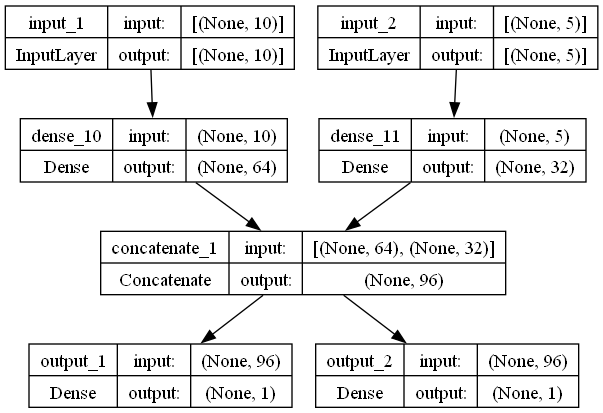

In [40]:
#可视化模型
from tensorflow import keras
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #导入load_model的模型会出错,信息有缺失


In [41]:
###<补充> 7.2.6 导出时指定签名 - 多签名
#不同签名完成不同推理任务：分类、回归、取embedding等


import numpy as np  
import tensorflow as tf  
from tensorflow.keras import layers, models  
  
# 生成一个简单的随机二分类数据集  
np.random.seed(42)  
num_samples = 1000  
num_features = 10  
X = np.random.randn(num_samples, num_features)  
y = np.random.randint(2, size=num_samples)  
  
# 定义模型  
model = models.Sequential([  
    layers.Dense(32, activation='relu', input_shape=(num_features,)),  
    layers.Dense(1, activation='sigmoid')  
])  
  
# 编译模型  
model.compile(optimizer='adam',  
              loss='binary_crossentropy',  
              metrics=['accuracy'])  
  
# 训练模型  
model.fit(X, y, epochs=5)  
  
# 定义签名函数：预测  
@tf.function(input_signature=[tf.TensorSpec(shape=[None, num_features], dtype=tf.float32)])  
def serve_predictions(inputs):  
    return model(inputs)  
  
# 定义签名函数：提取特征  
@tf.function(input_signature=[tf.TensorSpec(shape=[None, num_features], dtype=tf.float32)])  
def extract_features(inputs):  
    features = model.layers[-2].output  
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=features)  
    return intermediate_model(inputs)  
  
# 创建签名字典  
signatures = {  
    'serving_default': serve_predictions,  
    'predict': serve_predictions,  
    'extract_features': extract_features  
}  
  
# 保存模型，包括多个签名  
export_path = "__MobileNet/saved_model_with_multiple_signatures_custom_data"  
tf.saved_model.save(model, export_path, signatures=signatures)  
  
# 加载模型并使用签名进行推理  
loaded_model = tf.saved_model.load(export_path)  
  
# 使用默认签名（'serving_default'）进行预测  
prediction_input = tf.convert_to_tensor([X[0]], dtype=tf.float32)  
predictions = loaded_model(prediction_input)  
print("Predictions:", predictions.numpy())  
  
# 使用 'predict' 签名进行预测  
predictions = loaded_model.signatures['predict'](inputs=prediction_input)['output_0']  
print("Predictions:", predictions.numpy())  
  
# 使用 'extract_features' 签名提取特征  
features = loaded_model.signatures['extract_features'](inputs=prediction_input)['output_0']  
print("Extracted Features:", features.numpy())

Epoch 1/5
32/32 [==============================] - 1s 3ms/step - loss: 0.7184 - accuracy: 0.4970
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.7056 - accuracy: 0.5060
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5140
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5190
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5310
INFO:tensorflow:Assets written to: __MobileNet/saved_model_with_multiple_signatures_custom_data\assets


INFO:tensorflow:Assets written to: __MobileNet/saved_model_with_multiple_signatures_custom_data\assets


Predictions: [[0.47728625]]
Predictions: [[0.47728625]]
Extracted Features: [[0.         0.8003922  0.         0.8277885  0.43460467 0.20896778
  0.7957837  0.03497426 0.6207615  0.         0.4433204  0.
  0.6143159  0.10004097 0.21106642 0.8585887  0.         0.
  0.385815   0.7763254  0.45706096 0.52884555 0.24079818 0.7232761
  0.         0.         0.         0.04800992 0.         0.
  0.         0.2504902 ]]


In [44]:
loaded_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 10), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x1EE429CBD50>, 'predict': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 10), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x1EE46169F10>, 'extract_features': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 10), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 32), dtype=tf.float32, name='output_0')]] at 0x1EE46020210>})

In [42]:
list(loaded_model.signatures.keys())

['serving_default', 'predict', 'extract_features']

In [ ]:
## 总结
#模型导出时的签名，可简单理解为推理器，在TFServing等部署模型推理时使用。